In [7]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv("data/train.csv")[['Canonical_Smiles', 'Inhibition']]
df['mol'] = df['Canonical_Smiles'].apply(Chem.MolFromSmiles)
df = df[df['mol'].notnull()].reset_index(drop=True)

calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(df['mol'])
desc_numeric = desc.select_dtypes(include=[np.number])
desc_numeric = desc_numeric.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='median')
desc_imputed_array = imputer.fit_transform(desc_numeric)
desc_imputed = pd.DataFrame(desc_imputed_array, columns=desc_numeric.columns)
desc_imputed = desc_imputed.clip(upper=1e6)

X = desc_imputed
y = df['Inhibition'].values
cv = KFold(n_splits=5, shuffle=True, random_state=42)

 33%|███▎      | 556/1681 [00:04<00:07, 148.77it/s]

c:\Users\sbjan\miniconda3\envs\boost_env\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 79%|███████▉  | 1335/1681 [00:09<00:01, 203.69it/s]

c:\Users\sbjan\miniconda3\envs\boost_env\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1681/1681 [00:11<00:00, 152.30it/s]


In [9]:
def tune_lgbm(trial):
    import lightgbm as lgb
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'n_estimators': trial.suggest_int("n_estimators", 50, 300),
        'num_leaves': trial.suggest_int("num_leaves", 16, 64),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 10, 50),
        'min_gain_to_split': trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.6, 1.0),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.6, 1.0),
        'bagging_freq': 1,
        'lambda_l1': trial.suggest_float("lambda_l1", 0.0, 1.0),
        'lambda_l2': trial.suggest_float("lambda_l2", 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_xgboost(trial):
    import xgboost as xgb
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_catboost(trial):
    from catboost import CatBoostRegressor
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'verbose': 0
    }
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

In [10]:
models = {
    'LightGBM': tune_lgbm,
    'XGBoost': tune_xgboost,
    'CatBoost': tune_catboost
}

study_results = {}
for name, objective in models.items():
    print(f"Starting tuning for {name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    study_results[name] = {
        'best_score': study.best_value,
        'best_params': study.best_params
    }
    print(f"{name} done. Best RMSE: {study.best_value:.4f}")

[I 2025-07-03 10:14:46,599] A new study created in memory with name: no-name-f2e54895-2098-4cf1-8fb7-4122c2999a4f


Starting tuning for LightGBM...


[I 2025-07-03 10:14:48,543] Trial 0 finished with value: 25.59196732532416 and parameters: {'learning_rate': 0.19655262875090743, 'n_estimators': 196, 'num_leaves': 59, 'max_depth': 9, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.5514719979101593, 'feature_fraction': 0.6274323215906309, 'bagging_fraction': 0.6397007969666909, 'lambda_l1': 0.2920775038571226, 'lambda_l2': 0.8962562880180325}. Best is trial 0 with value: 25.59196732532416.
[I 2025-07-03 10:14:51,125] Trial 1 finished with value: 24.423753948646983 and parameters: {'learning_rate': 0.07009957129211901, 'n_estimators': 188, 'num_leaves': 51, 'max_depth': 10, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.7902643609301883, 'feature_fraction': 0.7150095264440374, 'bagging_fraction': 0.8642465319571543, 'lambda_l1': 0.25280344516616127, 'lambda_l2': 0.12558206498882507}. Best is trial 1 with value: 24.423753948646983.
[I 2025-07-03 10:14:51,960] Trial 2 finished with value: 25.902947389907855 and parameters: {'learning_rate

LightGBM done. Best RMSE: 23.7765
Starting tuning for XGBoost...


[I 2025-07-03 10:16:25,851] Trial 0 finished with value: 25.030487748059855 and parameters: {'learning_rate': 0.166395967564049, 'n_estimators': 213, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.698502447508135, 'colsample_bytree': 0.6265136323415365, 'reg_alpha': 0.03462612513855179, 'reg_lambda': 0.16044569289576072}. Best is trial 0 with value: 25.030487748059855.
[I 2025-07-03 10:16:38,568] Trial 1 finished with value: 25.695243236007038 and parameters: {'learning_rate': 0.24352292101127293, 'n_estimators': 282, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.788351929655553, 'colsample_bytree': 0.7592324788718486, 'reg_alpha': 0.44251467336798256, 'reg_lambda': 0.5425323983341053}. Best is trial 0 with value: 25.030487748059855.
[I 2025-07-03 10:16:48,047] Trial 2 finished with value: 24.97629658022269 and parameters: {'learning_rate': 0.15545500934737735, 'n_estimators': 206, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7850063029943424, 'colsample_bytree

XGBoost done. Best RMSE: 23.7690
Starting tuning for CatBoost...


[I 2025-07-03 10:27:15,839] Trial 0 finished with value: 24.60790171372528 and parameters: {'iterations': 265, 'learning_rate': 0.26690871837788627, 'depth': 6, 'l2_leaf_reg': 8.444118558647332, 'random_strength': 0.36557200225251196, 'bagging_temperature': 0.14512946077300615}. Best is trial 0 with value: 24.60790171372528.
[I 2025-07-03 10:40:29,900] Trial 1 finished with value: 24.701121093994544 and parameters: {'iterations': 289, 'learning_rate': 0.14667824318600486, 'depth': 10, 'l2_leaf_reg': 2.3665756589609344, 'random_strength': 0.38013428313537434, 'bagging_temperature': 0.2966438653762108}. Best is trial 0 with value: 24.60790171372528.
[I 2025-07-03 10:41:37,907] Trial 2 finished with value: 24.119834942557627 and parameters: {'iterations': 161, 'learning_rate': 0.11262177119319657, 'depth': 8, 'l2_leaf_reg': 6.321100655516933, 'random_strength': 0.3337543285598541, 'bagging_temperature': 0.2934481198663178}. Best is trial 2 with value: 24.119834942557627.
[I 2025-07-03 10:

CatBoost done. Best RMSE: 23.6335


In [11]:
def get_model(name, params):
    if name == "LightGBM":
        import lightgbm as lgb
        return lgb.LGBMRegressor(**params)
    elif name == "XGBoost":
        import xgboost as xgb
        return xgb.XGBRegressor(**params)
    elif name == "CatBoost":
        from catboost import CatBoostRegressor
        return CatBoostRegressor(verbose=0, **params)
    else:
        raise ValueError(f"Unknown model name: {name}")

model_names = []
rmse_scores = []

for name, res in study_results.items():
    model = get_model(name, res['best_params'])
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    mean_rmse = -scores.mean()
    model_names.append(name)
    rmse_scores.append(mean_rmse)

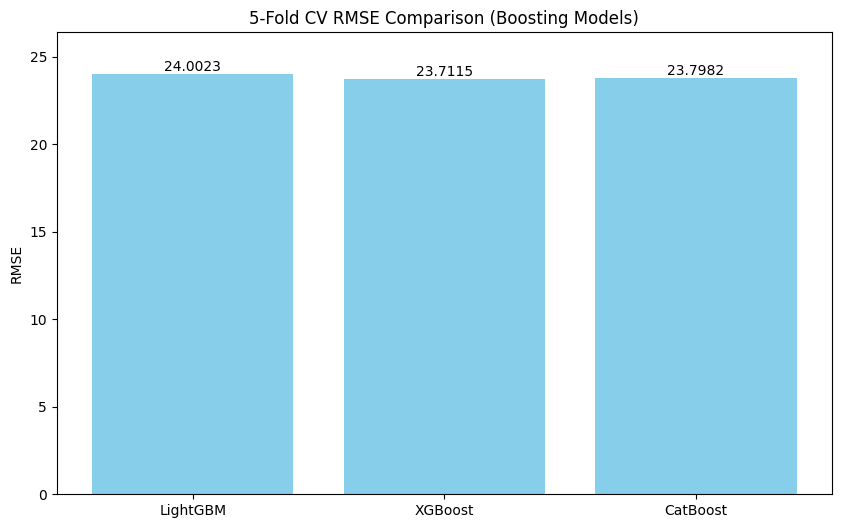

In [12]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_scores, color='skyblue')
plt.ylabel("RMSE")
plt.title("5-Fold CV RMSE Comparison (Boosting Models)")

for bar, rmse in zip(bars, rmse_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{rmse:.4f}", ha='center', va='bottom')

plt.ylim(0, max(rmse_scores)*1.1)
plt.show()

In [14]:
total_train_results = {}
for name, res in study_results.items():
    model = get_model(name, res['best_params'])
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    total_train_results[name] = rmse
    print(f"{name} - Train RMSE: {rmse:.4f}")

LightGBM - Train RMSE: 18.5768
XGBoost - Train RMSE: 17.3602
CatBoost - Train RMSE: 16.3618
